In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from itertools import chain

In [2]:
nucSegPath = 'segmentation/cellCycleEdUOnlyImage_P03_48hrs_48hrs-aorta1_nuclei7_seg.npy'
dfPath = 'results/firstWave/cluster1/thresholdedEDU_P03_a1_7.csv'

In [3]:
masks = np.load(nucSegPath, allow_pickle=True).item()['masks']
outlines = np.load(nucSegPath, allow_pickle=True).item()['outlines']
df = pd.read_csv(dfPath)

In [5]:
result = np.zeros_like(masks)
unique_labels = df['label'].unique()

# Iterate through the unique labels and update the values in the result array
# color-code nuclei by cluster
for label in unique_labels:
    result[masks == label] = label

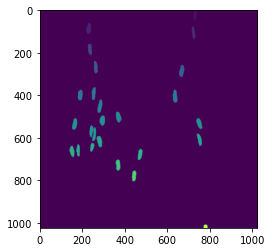

In [6]:
plt.imshow(result)

In [7]:
unique_labels = df['label'].unique()

# Create a mask that matches the unique labels in the segmentations array
mask = np.isin(masks, unique_labels)
outline = np.isin(outlines, unique_labels)


# Initialize a result array with the same shape as the segmentations array, filled with empty strings
result = np.empty(masks.shape, dtype=int)

result = np.where(masks !=0, 11, 0)
resultOutline = np.empty(masks.shape, dtype=int)
resultOutline = np.where(outlines !=0, 11, 0)

# Use the mask to update the result array with corresponding 'ID' values
#store nuclei color-coded by EdU cluster
result[mask] = df.set_index('label').loc[masks[mask], 'cluster']
resultOutline[outline] = df.set_index('label').loc[outlines[outline], 'cluster']

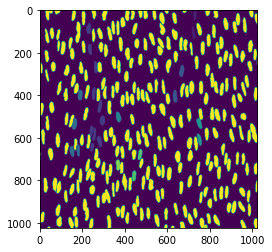

In [9]:
plt.imshow(result)

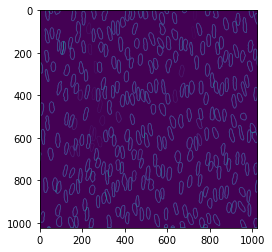

In [98]:
plt.imshow(resultOutline)

In [ ]:
#create csv for R plotting
masksNew = result
height, width = masksNew.shape
x_coords, y_coords = np.meshgrid(range(width), range(height))
values = masksNew.flatten()

x_coords = np.reshape(x_coords, (-1, 1))
y_coords = np.reshape(y_coords, (-1, 1))
result = np.column_stack((x_coords, y_coords, values))
df = pd.DataFrame(result, columns=['x', 'y', 'value'])
df['y_new'] = masksNew.shape[0] - df['y']


In [274]:
df.to_csv('results/nucleiClustered.csv', index=False)

cell shape segmentation

In [10]:
cellShapeSegPath = 'segmentation/cellSizeEdUOnlyImage_P03_48hrs_aorta01_cel_seg.npy'

In [11]:
shapes = np.load(cellShapeSegPath, allow_pickle=True).item()['masks']

In [12]:
mapping = {}
cellsMarked = []
for label in np.unique(result):
    if label != 0:
        if label != 11:
            shapeIDs = np.unique(shapes[np.where(result==label)])
            shapeIDs = shapeIDs[np.nonzero(shapeIDs)]
            mapping[label] = shapeIDs
            cellsMarked.append(shapeIDs)


In [15]:
cellsMarked = list(chain.from_iterable(cellsMarked))

In [28]:
cellShapeSegPath = 'segmentation/cellSizeEdUOnlyImage_P03_48hrs_aorta01_cel_seg.npy'
shapes = np.load(cellShapeSegPath, allow_pickle=True).item()['masks']
outlines = np.zeros(shapes.shape)
thickness = 1

for label in np.unique(shapes):
    if label != 0:
        maskFilt  = np.where(shapes == label, 1, 0)
        contours = find_contours(maskFilt.astype(float), level=0.5)[0]
        contours = contours.astype(int)
        contoursImage = np.zeros(shapes.shape)
        #result_array = np.zeros_like(masks.shape, dtype=np.uint8)
        contoursImage[contours[:,0], contours[:,1]] = 1
        labelNEW = 11

        for c in contours:
            for i in range(thickness):
                if (c[0] + i) < (shapes.shape[0] -1):
                    contoursImage[c[0] + i, c[1]] = 1
                if (c[0] - i) > 0:
                    contoursImage[c[0] - i, c[1]] = 1
                if (c[1] + i) < (shapes.shape[1] -1):
                    contoursImage[c[0], c[1] + i] = 1
                if (c[1] - i) > 0:
                    contoursImage[c[0], c[1]-i] = 1

        outlines[np.where(contoursImage==1)]= labelNEW




outlines = outlines.astype(int)

In [74]:
height, width = outlines.shape
x_coords, y_coords = np.meshgrid(range(width), range(height))
values = outlines.flatten()

x_coords = np.reshape(x_coords, (-1, 1))
y_coords = np.reshape(y_coords, (-1, 1))
result = np.column_stack((x_coords, y_coords, values))
df = pd.DataFrame(result, columns=['x', 'y', 'value'])
df['y_new'] = outlines.shape[0] - df['y']

In [56]:
#save cell shape colored by Edu cluster as csv file to plot in ggplot

savePath = 'results/cellShapesSameValue.csv'

df.to_csv(savePath, index=False)